https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

In [89]:
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [90]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()
        self.num_actions = num_actions
        
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0)) # easy for computing gradient and add batch to input
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        return value, policy_dist

In [91]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):

            value, policy_dist = actor_critic.forward(state) # getting the predicted value and action probability distribution
        
            # detach the tensor from requiring gradient
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))

            log_prob = torch.log(policy_dist.squeeze(0)[action]) # calculate log of probability of the action we just took
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            if done or steps == num_steps-1: # if episode terminates
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]

                # for graph
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))

                if episode % 10 == 0:                    
                    print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break

        # compute G
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        values = torch.FloatTensor(values) # predicted Q
        Qvals = torch.FloatTensor(Qvals) # G
        log_probs = torch.stack(log_probs)

        # update actor critic

        advantage = Qvals - values

        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

    return actor_critic

episode: 0, reward: 26.0, total length: 25, average length: 25.0 

episode: 10, reward: 18.0, total length: 17, average length: 14.8 

episode: 20, reward: 13.0, total length: 12, average length: 15.9 

episode: 30, reward: 9.0, total length: 8, average length: 12.5 

episode: 40, reward: 12.0, total length: 11, average length: 13.9 

episode: 50, reward: 11.0, total length: 10, average length: 12.7 

episode: 60, reward: 22.0, total length: 21, average length: 12.4 

episode: 70, reward: 13.0, total length: 12, average length: 15.1 

episode: 80, reward: 25.0, total length: 24, average length: 16.8 

episode: 90, reward: 21.0, total length: 20, average length: 19.6 

episode: 100, reward: 14.0, total length: 13, average length: 17.8 

episode: 110, reward: 12.0, total length: 11, average length: 16.3 

episode: 120, reward: 15.0, total length: 14, average length: 21.5 

episode: 130, reward: 17.0, total length: 16, average length: 15.9 

episode: 140, reward: 11.0, total length: 10, a

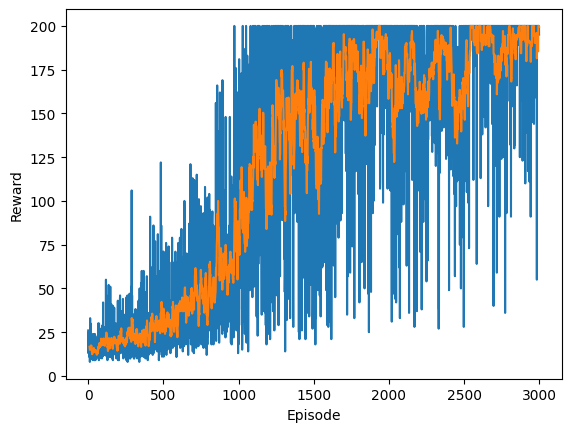

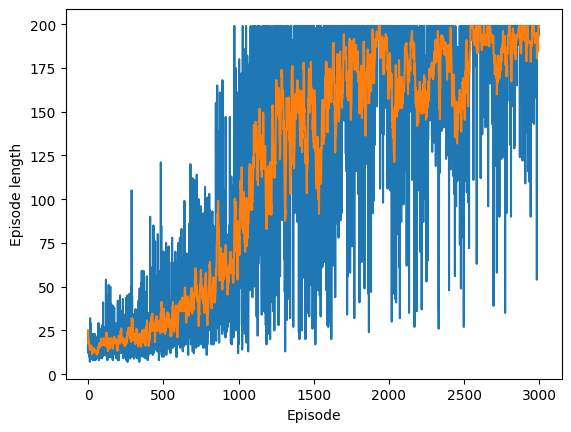

ActorCritic(
  (actor_linear1): Linear(in_features=4, out_features=256, bias=True)
  (actor_linear2): Linear(in_features=256, out_features=2, bias=True)
  (critic_linear1): Linear(in_features=4, out_features=256, bias=True)
  (critic_linear2): Linear(in_features=256, out_features=1, bias=True)
)


In [92]:
env = gym.make("CartPole-v0")
agent = a2c(env)
print(agent)

In [88]:
# old agent play game
state = env.reset()
done = False
num_outputs = env.action_space.n

while not done:
    _, policy_dist = agent.forward(state)
    dist = dist = policy_dist.detach().numpy()
    action = np.random.choice(num_outputs, p=np.squeeze(dist))
    state, reward, done, _ = env.step(action)
    env.render()

env.close()